# Predicting user travel satisfaction



---
- Predicting user travel satisfaction. Understanding and enhancing travel experiences is crucial for the tourism industry
- The dataset contains 19800 samples with 10 columns

#### Data source
- https://www.kaggle.com/datasets/gauravduttakiit/predicting-user-travel-satisfaction

---
#### Columns
- Trip ID: Representing the trip unique ID
- User ID: Representing a user's unique ID
- Destination: The destination of the trip
- Departure Date: The day the trip start
- Return Date: The day of returning from the trip
- Travel Type: Either Family, Leisure, Business, Adventure, Beach, Family
- Transportation Mode: Either Bus, Flight, Cruise, Train or Car
- Hotel Rating: A value of 1 to 5 for the rating of the hotel used during the trip
- Total Cost ($): The total cost of the hotel in American Dollars
- Customer_Satisfaction: The target variable, a value from 1 to 10, presrenting how satisfied the user is about the trip

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr, skew, gmean
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

sns.set_theme(style="darkgrid") # for theme | "darkgrid", "whitegrid", "dark", "white", "ticks"
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
df = pd.read_csv("./dataset/Train.csv")
df

Trip ID   User ID Destination Departure Date Return Date Travel Type  \
0        TRIP001  USER6303      Sydney     28-07-2024  14-09-2024    Cultural   
1        TRIP002  USER1398       Tokyo     04-01-2025  20-02-2025     Leisure   
2        TRIP003  USER8452    New York     14-09-2024  06-03-2025    Business   
3        TRIP004  USER5289      Sydney     06-07-2024  14-08-2024   Adventure   
4        TRIP005  USER9783    New York     26-08-2024  25-11-2024    Cultural   
...          ...       ...         ...            ...         ...         ...   
19795  TRIP19996  USER4173    Istanbul     26-04-2024  04-06-2024     Leisure   
19796  TRIP19997  USER2394   Barcelona     13-09-2024  25-09-2024     Leisure   
19797  TRIP19998  USER6638     Bangkok     23-12-2024  26-12-2024    Cultural   
19798  TRIP19999  USER8763    New York     30-01-2025  05-04-2025     Leisure   
19799  TRIP20000  USER3844      Sydney     23-12-2024  04-01-2025     Leisure   

      Transportation Mode  Hotel Rating  Total Cost ($)  Customer_Satisfaction  
0                     Bus             4         2297.38                      1  
1                  Flight             3         4171.03                      1  
2                  Cruise             4          695.11                      3  
3                  Flight             2         1371.81                      3  
4                     Bus             2          691.52                      7  
...                   ...           ...             ...                    ...  
19795                 Bus             5         1954.61                      1  
19796                 Bus             4         3868.49                      8  
19797                 Car             4         2255.53                      2  
19798              Cruise             4         4630.54                     10  
19799              Cruise             5         4093.76                      6  

[19800 rows x 10 columns]

# Data Preprocessing

### Normalise Columns
- make column names a single name and all columns must be lower case

In [3]:
df.columns = [ c.lower().replace(" ", "_") for c in df.columns ]
df.columns

Index(['trip_id', 'user_id', 'destination', 'departure_date', 'return_date',
       'travel_type', 'transportation_mode', 'hotel_rating', 'total_cost_($)',
       'customer_satisfaction'],
      dtype='object')

### Check for null data

In [4]:
df.isna().sum().to_frame().T

trip_id  user_id  destination  departure_date  return_date  travel_type  \
0        0        0            0               0            0            0   

   transportation_mode  hotel_rating  total_cost_($)  customer_satisfaction  
0                    0             0               0                      0

In [5]:
df.isnull().sum().to_frame().T

trip_id  user_id  destination  departure_date  return_date  travel_type  \
0        0        0            0               0            0            0   

   transportation_mode  hotel_rating  total_cost_($)  customer_satisfaction  
0                    0             0               0                      0

### Columns Data Types

In [6]:
df.dtypes.to_frame().T

trip_id user_id destination departure_date return_date travel_type  \
0  object  object      object         object      object      object   

  transportation_mode hotel_rating total_cost_($) customer_satisfaction  
0              object        int64        float64                 int64

### Data Information

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19800 entries, 0 to 19799
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trip_id                19800 non-null  object 
 1   user_id                19800 non-null  object 
 2   destination            19800 non-null  object 
 3   departure_date         19800 non-null  object 
 4   return_date            19800 non-null  object 
 5   travel_type            19800 non-null  object 
 6   transportation_mode    19800 non-null  object 
 7   hotel_rating           19800 non-null  int64  
 8   total_cost_($)         19800 non-null  float64
 9   customer_satisfaction  19800 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.5+ MB


### Statistical Description Of Numeric Columns

In [8]:
df.describe()

hotel_rating  total_cost_($)  customer_satisfaction
count  19800.000000    19800.000000           19800.000000
mean       3.000202     2739.438110               5.511212
std        1.407734     1301.720853               2.879006
min        1.000000      500.040000               1.000000
25%        2.000000     1606.932500               3.000000
50%        3.000000     2730.600000               6.000000
75%        4.000000     3862.110000               8.000000
max        5.000000     4999.580000              10.000000

### Normalise the Dates Columns - Departure and Return Date
- The data should be seperated into, day, month, year, 
- This will help me understand/get insight and visualise the different months and years in the dataset
- Calculate difference in number of days between departure date and return data

In [9]:
df['departure_date'] = pd.to_datetime(df['departure_date'], format='%d-%m-%Y')
df['return_date'] = pd.to_datetime(df['return_date'], format='%d-%m-%Y')
# # 
df['departure_day'] = df['departure_date'].dt.day
df['departure_month'] = df['departure_date'].dt.month
df['departure_year'] = df['departure_date'].dt.year
# 
df['return_year'] = df['return_date'].dt.year
df['return_month'] = df['return_date'].dt.month
df['return_day'] = df['return_date'].dt.day
# 
df['trip_duration'] = (df['return_date'] - df['departure_date']).dt.days
# 
df.head()

trip_id   user_id destination departure_date return_date travel_type  \
0  TRIP001  USER6303      Sydney     2024-07-28  2024-09-14    Cultural   
1  TRIP002  USER1398       Tokyo     2025-01-04  2025-02-20     Leisure   
2  TRIP003  USER8452    New York     2024-09-14  2025-03-06    Business   
3  TRIP004  USER5289      Sydney     2024-07-06  2024-08-14   Adventure   
4  TRIP005  USER9783    New York     2024-08-26  2024-11-25    Cultural   

  transportation_mode  hotel_rating  total_cost_($)  customer_satisfaction  \
0                 Bus             4         2297.38                      1   
1              Flight             3         4171.03                      1   
2              Cruise             4          695.11                      3   
3              Flight             2         1371.81                      3   
4                 Bus             2          691.52                      7   

   departure_day  departure_month  departure_year  return_year  return_month  \
0             28                7            2024         2024             9   
1              4                1            2025         2025             2   
2             14                9            2024         2025             3   
3              6                7            2024         2024             8   
4             26                8            2024         2024            11   

   return_day  trip_duration  
0          14             48  
1          20             47  
2           6            173  
3          14             39  
4          25             91

### Duplicate Values
- There is 0 zero duplicates values

In [10]:
df.duplicated().sum()

0

# Descriptive Statistics

In [11]:
df.head()

trip_id   user_id destination departure_date return_date travel_type  \
0  TRIP001  USER6303      Sydney     2024-07-28  2024-09-14    Cultural   
1  TRIP002  USER1398       Tokyo     2025-01-04  2025-02-20     Leisure   
2  TRIP003  USER8452    New York     2024-09-14  2025-03-06    Business   
3  TRIP004  USER5289      Sydney     2024-07-06  2024-08-14   Adventure   
4  TRIP005  USER9783    New York     2024-08-26  2024-11-25    Cultural   

  transportation_mode  hotel_rating  total_cost_($)  customer_satisfaction  \
0                 Bus             4         2297.38                      1   
1              Flight             3         4171.03                      1   
2              Cruise             4          695.11                      3   
3              Flight             2         1371.81                      3   
4                 Bus             2          691.52                      7   

   departure_day  departure_month  departure_year  return_year  return_month  \
0             28                7            2024         2024             9   
1              4                1            2025         2025             2   
2             14                9            2024         2025             3   
3              6                7            2024         2024             8   
4             26                8            2024         2024            11   

   return_day  trip_duration  
0          14             48  
1          20             47  
2           6            173  
3          14             39  
4          25             91

In [12]:
numeric_columns = ['total_cost_($)','trip_duration', 'return_month','departure_month' ]

### Samples Count
- There is 19800 samples in this dataset

In [13]:
num_samples = df.shape[0]
num_samples

19800

### Sum of numeric columns

In [14]:
df.head()

trip_id   user_id destination departure_date return_date travel_type  \
0  TRIP001  USER6303      Sydney     2024-07-28  2024-09-14    Cultural   
1  TRIP002  USER1398       Tokyo     2025-01-04  2025-02-20     Leisure   
2  TRIP003  USER8452    New York     2024-09-14  2025-03-06    Business   
3  TRIP004  USER5289      Sydney     2024-07-06  2024-08-14   Adventure   
4  TRIP005  USER9783    New York     2024-08-26  2024-11-25    Cultural   

  transportation_mode  hotel_rating  total_cost_($)  customer_satisfaction  \
0                 Bus             4         2297.38                      1   
1              Flight             3         4171.03                      1   
2              Cruise             4          695.11                      3   
3              Flight             2         1371.81                      3   
4                 Bus             2          691.52                      7   

   departure_day  departure_month  departure_year  return_year  return_month  \
0             28                7            2024         2024             9   
1              4                1            2025         2025             2   
2             14                9            2024         2025             3   
3              6                7            2024         2024             8   
4             26                8            2024         2024            11   

   return_day  trip_duration  
0          14             48  
1          20             47  
2           6            173  
3          14             39  
4          25             91

In [15]:
col_sums = df[numeric_columns].sum()
col_sums.to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0     54240874.57      2106863.0      108762.0         129054.0

### Modes

In [16]:
df[numeric_columns].mode().iloc[0]

total_cost_($)     572.82
trip_duration       34.00
return_month         3.00
departure_month      5.00
Name: 0, dtype: float64

### Median

In [17]:
df[numeric_columns].median().to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0          2730.6           82.0           4.0              7.0

### Mean

In [18]:
col_means = col_sums / num_samples
col_means.to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0      2739.43811     106.407222       5.49303         6.517879

### Columns Ranges
- Show the difference the min value and the max value in each column

In [19]:
(df[numeric_columns].max() - df[numeric_columns].min()).to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0         4499.54          392.0          11.0             11.0

### Standard Deviation - Sample
- To show how the data samples are spread from the mean in each column

In [20]:
df[numeric_columns].std().to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0     1301.720853      87.629669      3.866118         3.446676

### Variance
- The square of standard deviation to show how the data are spread from the mean, this is not a good way and does not show as much as the standard deviation because the values are squared

In [21]:
df[numeric_columns].var().to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0    1.694477e+06    7678.958915     14.946868        11.879573

### Quantile Ranges

In [22]:
df[numeric_columns].quantile([0.25, 0.5, 0.75])

total_cost_($)  trip_duration  return_month  departure_month
0.25       1606.9325           34.0           2.0              4.0
0.50       2730.6000           82.0           4.0              7.0
0.75       3862.1100          161.0          10.0              9.0

### Z-Score 

In [23]:
df[numeric_columns] - df[numeric_columns].mean()

total_cost_($)  trip_duration  return_month  departure_month
0          -442.05811     -58.407222       3.50697         0.482121
1          1431.59189     -59.407222      -3.49303        -5.517879
2         -2044.32811      66.592778      -2.49303         2.482121
3         -1367.62811     -67.407222       2.50697         0.482121
4         -2047.91811     -15.407222       5.50697         1.482121
...               ...            ...           ...              ...
19795      -784.82811     -67.407222       0.50697        -2.517879
19796      1129.05189     -94.407222       3.50697         2.482121
19797      -483.90811    -103.407222       6.50697         5.482121
19798      1891.10189     -41.407222      -1.49303        -5.517879
19799      1354.32189     -94.407222      -4.49303         5.482121

[19800 rows x 4 columns]

### Coeficient of Variance
- To show how the values are around the mean
- High value tell that, more values are around the mean
- Lower value tell, that values are far from the mean

In [24]:
mean_values = df[numeric_columns].mean()
std_values = df[numeric_columns].std()

coefficient_of_variation = (std_values / mean_values)
coefficient_of_variation.to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0        0.475178       0.823531      0.703822         0.528803

### Standard error
- To show how far the sample data is from the populations data

In [25]:
standard_errors = df[numeric_columns].apply(lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
standard_errors.to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0        9.250927       0.622757      0.027475         0.024494

### Geometric Mean

In [26]:
# gmean( df[numeric_columns] )
for col in df[numeric_columns].columns:
  print(f"{col}    \t {gmean(df[numeric_columns][col])}")

total_cost_($)    	 2362.6540722276395
trip_duration    	 0.0
return_month    	 4.095430402473597
departure_month    	 5.304668501762167


### Chebychevs Theorem
- Show the data is distributed around the mean without considering the shape of the data

In [27]:
def calculate_chebyshev(df, k=2):

    means = df.mean()
    stds = df.std()
    
    results = pd.DataFrame({
        'Mean': means,
        'Std_Dev': stds,
        'Lower_Bound': means - k * stds,
        'Upper_Bound': means + k * stds,
        'Min_Proportion': 1 - (1 / (k**2))
    })
    
    actual_proportions = []
    for column in df.columns:
        col_data = df[column]
        lower = means[column] - k * stds[column]
        upper = means[column] + k * stds[column]
        proportion = ((col_data >= lower) & (col_data <= upper)).mean()
        actual_proportions.append(proportion)
    
    results['Actual_Proportion'] = actual_proportions
    
    return results

result = calculate_chebyshev(df[numeric_columns], k=2)

result

Mean      Std_Dev  Lower_Bound  Upper_Bound  \
total_cost_($)   2739.438110  1301.720853   135.996404  5342.879815   
trip_duration     106.407222    87.629669   -68.852116   281.666561   
return_month        5.493030     3.866118    -2.239206    13.225266   
departure_month     6.517879     3.446676    -0.375473    13.411230   

                 Min_Proportion  Actual_Proportion  
total_cost_($)             0.75           1.000000  
trip_duration              0.75           0.948485  
return_month               0.75           1.000000  
departure_month            0.75           1.000000

### Mean Abs Deviation

In [28]:
mean = df[numeric_columns].mean()
abs(df[numeric_columns] - mean).mean().to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0     1127.096451       71.96917      3.516619         2.990633

### Confidence Level

In [29]:
confidence = 0.95
# 
stats_df_mean = df[numeric_columns].mean()
n = df.shape[0]
stderr = stats.sem(df[numeric_columns])
interval = stderr * stats.t.ppf( ( 1 + confidence ) / 2.0, n - 1)
# 
(stats_df_mean - interval).round(3).to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0        2721.306        105.187         5.439             6.47

### Kurtosis
- A statistical measure that describe the tails of a distribution of data

In [30]:
df[numeric_columns].kurtosis().to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0       -1.200434       0.009293     -1.319526        -1.201004

### Skewness
- Explains how the lopsided the data is
- Positive : means the data is skewed to the right
- Negative : means the data is skewed to the left

In [31]:
df[numeric_columns].apply(skew).to_frame().T

total_cost_($)  trip_duration  return_month  departure_month
0        0.008211        0.91198      0.515839        -0.008836

# Data Visualisation

In [32]:
df.head()

trip_id   user_id destination departure_date return_date travel_type  \
0  TRIP001  USER6303      Sydney     2024-07-28  2024-09-14    Cultural   
1  TRIP002  USER1398       Tokyo     2025-01-04  2025-02-20     Leisure   
2  TRIP003  USER8452    New York     2024-09-14  2025-03-06    Business   
3  TRIP004  USER5289      Sydney     2024-07-06  2024-08-14   Adventure   
4  TRIP005  USER9783    New York     2024-08-26  2024-11-25    Cultural   

  transportation_mode  hotel_rating  total_cost_($)  customer_satisfaction  \
0                 Bus             4         2297.38                      1   
1              Flight             3         4171.03                      1   
2              Cruise             4          695.11                      3   
3              Flight             2         1371.81                      3   
4                 Bus             2          691.52                      7   

   departure_day  departure_month  departure_year  return_year  return_month  \
0             28                7            2024         2024             9   
1              4                1            2025         2025             2   
2             14                9            2024         2025             3   
3              6                7            2024         2024             8   
4             26                8            2024         2024            11   

   return_day  trip_duration  
0          14             48  
1          20             47  
2           6            173  
3          14             39  
4          25             91

### Customer Satisfaction and Trip Total Cost
- there is no linear relationship between customer satisfaction and trip total cost
- The correlation score is very clost to zero
- The p-value(0.950) shows that, trip cost does not influence customer satisfaction

In [33]:
corr, p_value = spearmanr(df['total_cost_($)'], df['customer_satisfaction'])
print(f"Spearman Correlation: {corr:.3f}, p-value: {p_value:.3f}")

Spearman Correlation: -0.000, p-value: 0.950


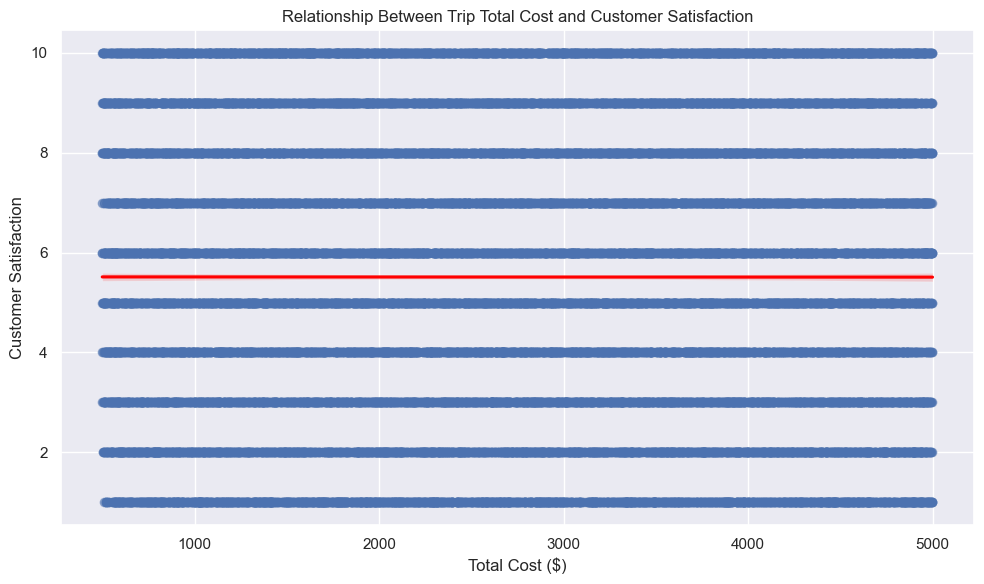

In [34]:
plt.figure(figsize=(10, 6))
sns.regplot(x='total_cost_($)', y='customer_satisfaction', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Relationship Between Trip Total Cost and Customer Satisfaction')
plt.xlabel('Total Cost ($)')
plt.ylabel('Customer Satisfaction')
plt.tight_layout()
plt.show()

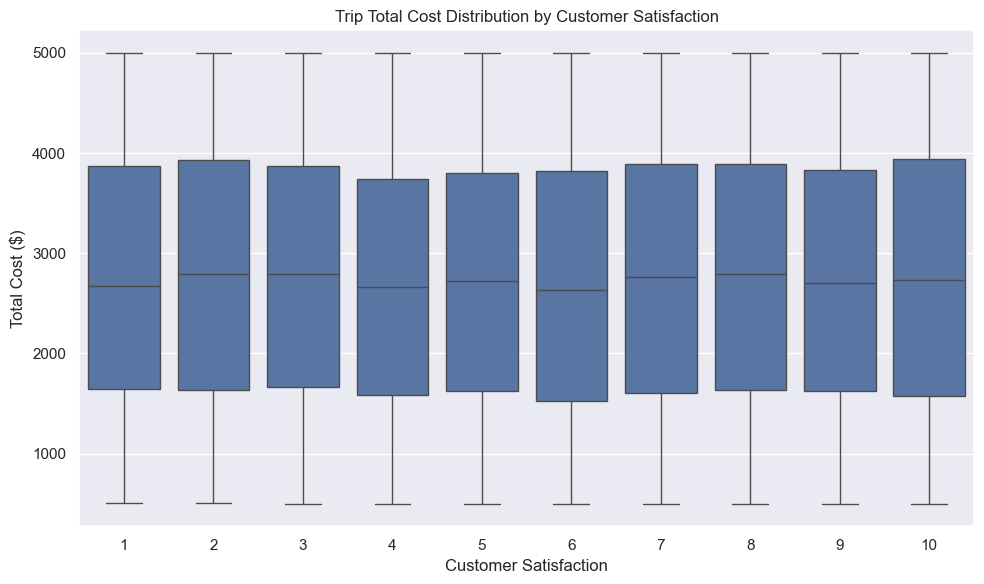

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='customer_satisfaction', y='total_cost_($)', data=df)

plt.title('Trip Total Cost Distribution by Customer Satisfaction')
plt.xlabel('Customer Satisfaction')
plt.ylabel('Total Cost ($)')
plt.tight_layout()
plt.show()

### Trip Duration
- The data is skewed. I used log transform to handle outliers.

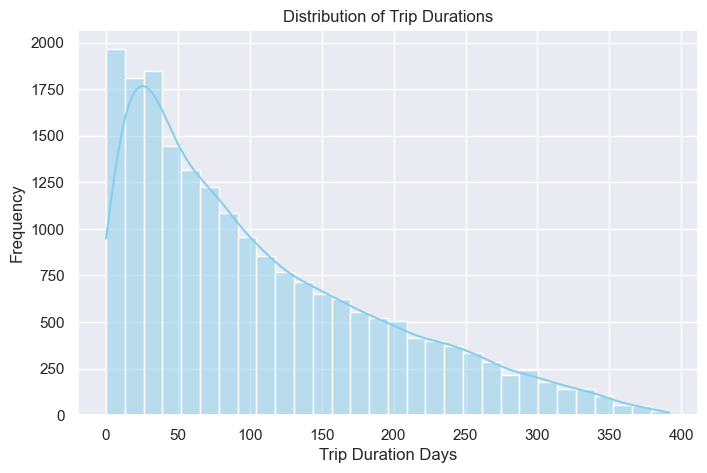

In [36]:
df['trip_duration'].describe()

plt.figure(figsize=(8, 5))
sns.histplot(
  data=df,
  x='trip_duration',
  bins=30,
  kde=True,
  color='skyblue'
)
plt.title("Distribution of Trip Durations")
plt.xlabel("Trip Duration Days")
plt.ylabel('Frequency')
plt.show()

### Trip Duration Days and Customer Satisfaction
- There is a lot of outliers, this will be handled using log transform
- There is no strong linear correlation that the trip duration influence the customer satisfaction
- The spearman p-value<0.148> is more than 0.05, I'll reject the idea of the trip duration influencing customer satisfaction

In [37]:
corr, p_value = spearmanr(df['trip_duration'], df['customer_satisfaction'])
print(f"Spearman Correlation: {corr:.3f}, p-value: {p_value:.3f}")

Spearman Correlation: 0.010, p-value: 0.148


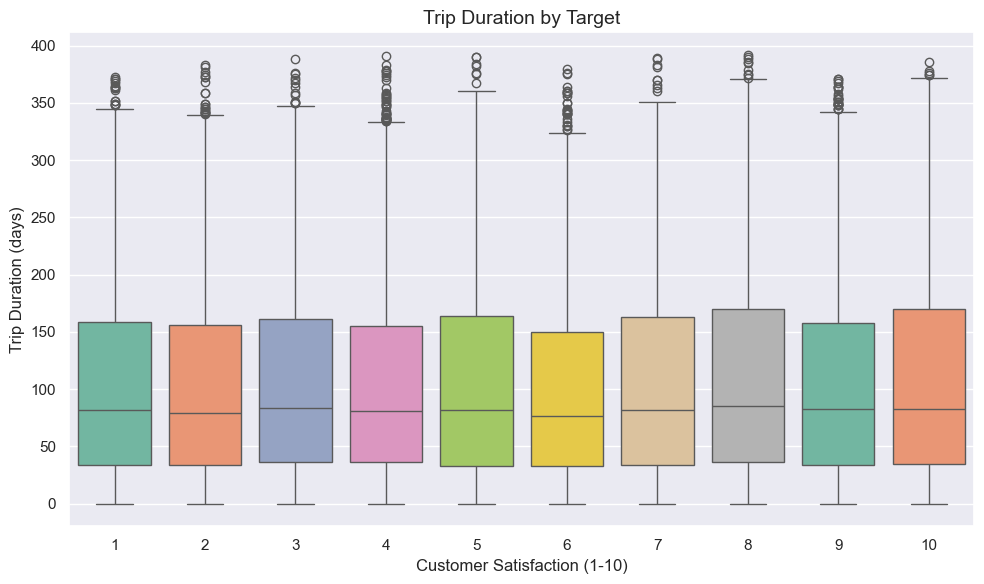

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(
  x='customer_satisfaction', 
  y='trip_duration', 
  data=df, 
  palette='Set2'
)

plt.title('Trip Duration by Target', fontsize=14)
plt.xlabel('Customer Satisfaction (1-10)', fontsize=12)
plt.ylabel('Trip Duration (days)', fontsize=12)
plt.tight_layout()
plt.show()

### Trip Total Cost 
- The least amount spend on the entire trip is $500.04
- The most amount spend is $4999.58
- The mean amount spend is $2739.43
- The standard deviation amount spend is $1301.72

In [39]:
df['total_cost_($)'].describe().to_frame().T

count        mean          std     min        25%     50%  \
total_cost_($)  19800.0  2739.43811  1301.720853  500.04  1606.9325  2730.6   

                    75%      max  
total_cost_($)  3862.11  4999.58

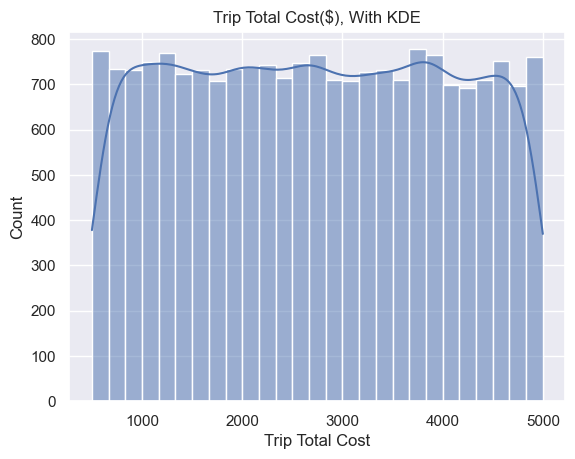

In [40]:
sns.histplot(data=df, x='total_cost_($)', kde=True)
plt.title("Trip Total Cost($), With KDE")
plt.xlabel("Trip Total Cost")
plt.show()

### Trip Cost - Customer Satisfaction
- From the regression plot, there is no increasing or decreasing line showing the trend between the trip duration and the total cost

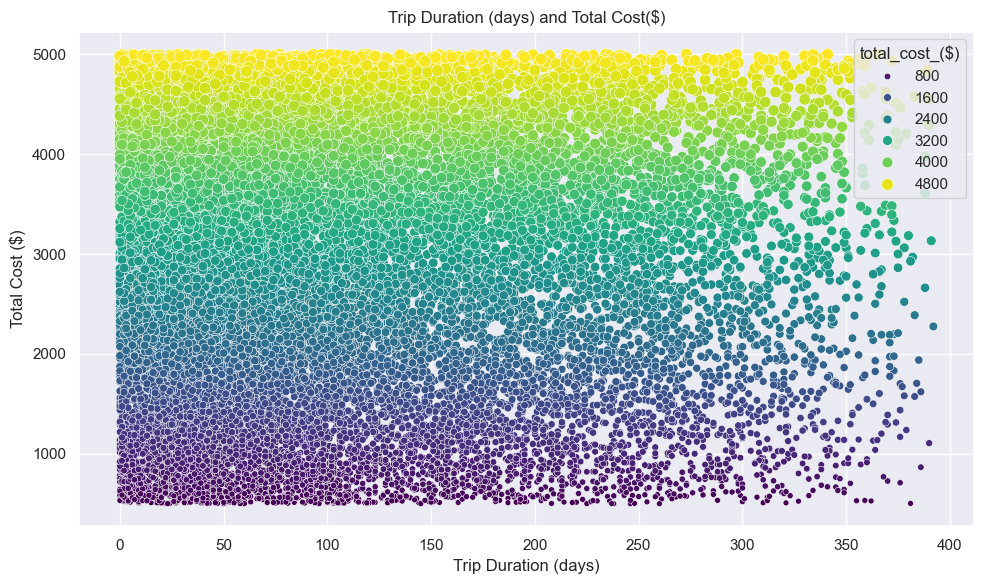

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="trip_duration", y="total_cost_($)", data=df, size="total_cost_($)", hue="total_cost_($)", palette="viridis")

plt.title("Trip Duration (days) and Total Cost($)")
plt.xlabel("Trip Duration (days)")
plt.ylabel("Total Cost ($)")

plt.tight_layout()
plt.show()

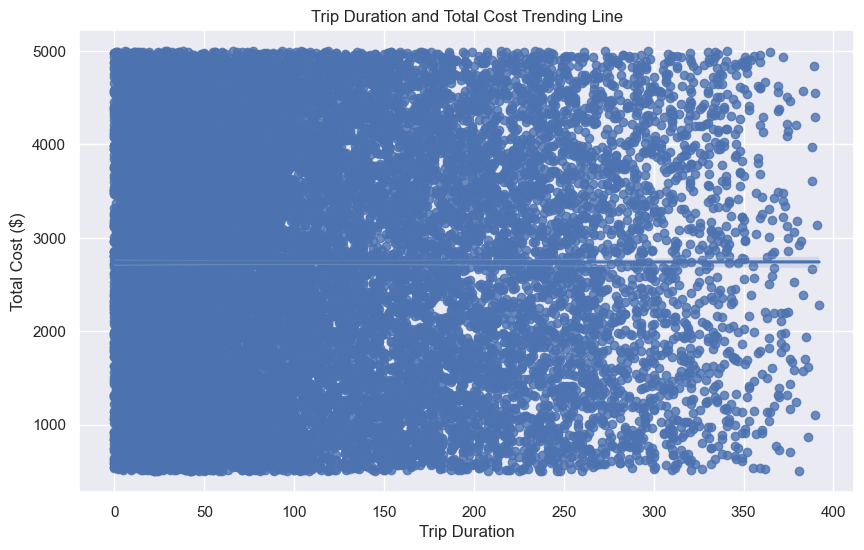

In [42]:
plt.figure(figsize=(10, 6))
sns.regplot(x="trip_duration", y="total_cost_($)", data=df)
plt.title("Trip Duration and Total Cost Trending Line")
plt.ylabel("Total Cost ($)")
plt.xlabel("Trip Duration")
plt.show()

### Hotel Rating Distribution

In [43]:
corr, p_value = spearmanr(df['total_cost_($)'], df['customer_satisfaction'])
print(f"Spearman Correlation: {corr:.3f}, p-value: {p_value:.3f}")

Spearman Correlation: -0.000, p-value: 0.950


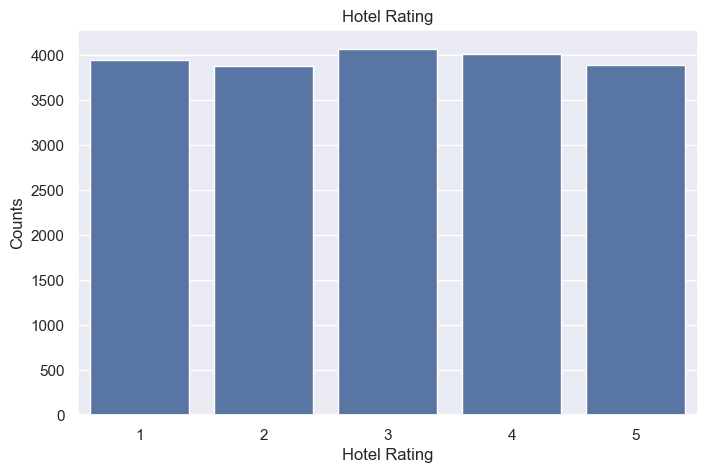

In [44]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='hotel_rating')
plt.title("Hotel Rating")
plt.xlabel("Hotel Rating")
plt.ylabel("Counts")
plt.show()

### Customer Satisfaction and Hotel Rating
- There is no linear relationshio between hotel rating and customer satisfaction
- The correlation score is 0
- The p-value(0.995), suggesting that there is no influence on customer satisfaction and hotel rating

In [45]:
corr, p_value = spearmanr(df['hotel_rating'], df['customer_satisfaction'])
print(f"Spearman Correlation: {corr:.3f}, p-value: {p_value:.3f}")

Spearman Correlation: 0.000, p-value: 0.995


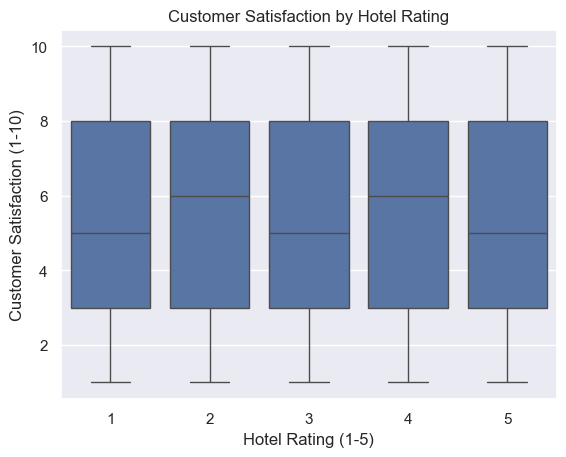

In [46]:
sns.boxplot(x="hotel_rating", y="customer_satisfaction", data=df)
plt.xlabel("Hotel Rating (1-5)")
plt.ylabel("Customer Satisfaction (1-10)")
plt.title("Customer Satisfaction by Hotel Rating")
plt.show()

### Transportation Mode
- The 5 mode of transportation include, train, flight, cruise, bus and car. Transportation by car have the most frequency

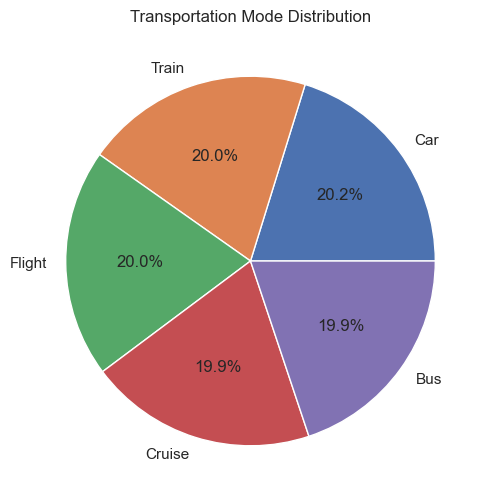

In [47]:
plt.figure(figsize=(10, 6))
df['transportation_mode'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title(
  "Transportation Mode Distribution",
)
plt.ylabel("")
plt.show()

### Travel Type
- There is 6 travel types in the dataset, with cultural having the most trips

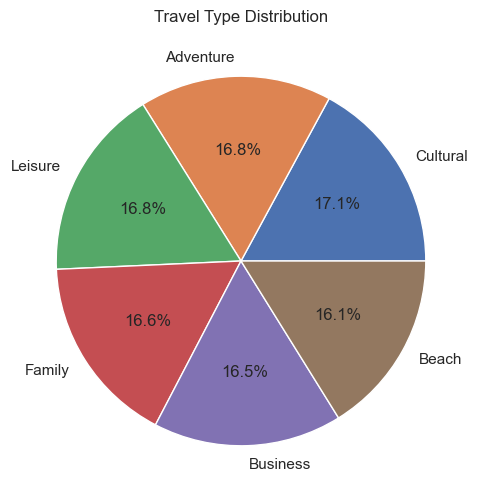

In [48]:
plt.figure(figsize=(10, 6))
df['travel_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title(
  "Travel Type Distribution",
)
plt.ylabel("")
plt.show()

### Destination Countries Frequency
- The most destination country is, Instanbul
- The least destination country from the dataset is Tokyo

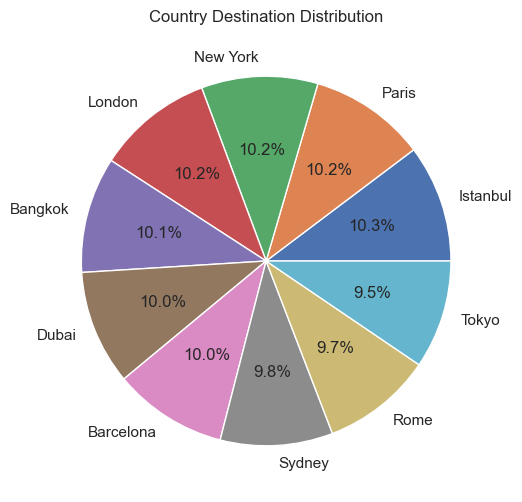

In [49]:
plt.figure(figsize=(10, 6))
df['destination'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title(
  "Country Destination Distribution",
)
plt.ylabel("")
plt.show()

### Target classes distribution
- The dataset classes, is fairly distributed between the 10 classes

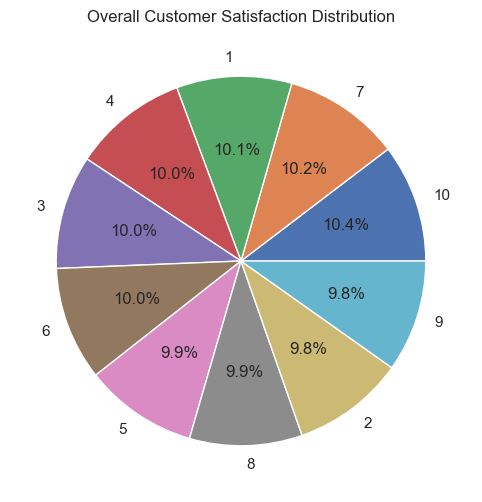

In [50]:
plt.figure(figsize=(10, 6))
df['customer_satisfaction'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title(
  "Overall Customer Satisfaction Distribution",
  # pad=10, fontsize=16, fontweight='bold'
)
plt.ylabel("")
plt.show()

### Travel Month

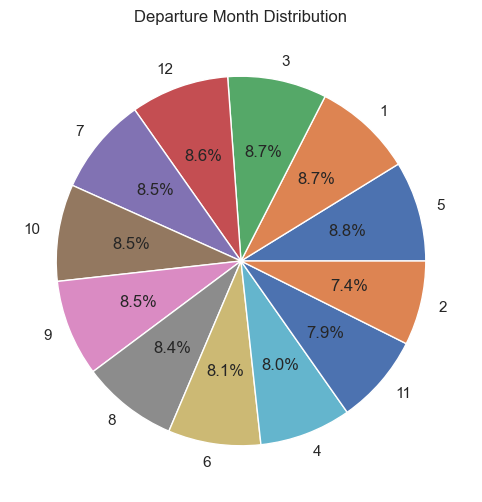

In [51]:
plt.figure(figsize=(10, 6))
df['departure_month'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title(
  "Departure Month Distribution",
)
plt.ylabel("")
plt.show()

### Departure Day

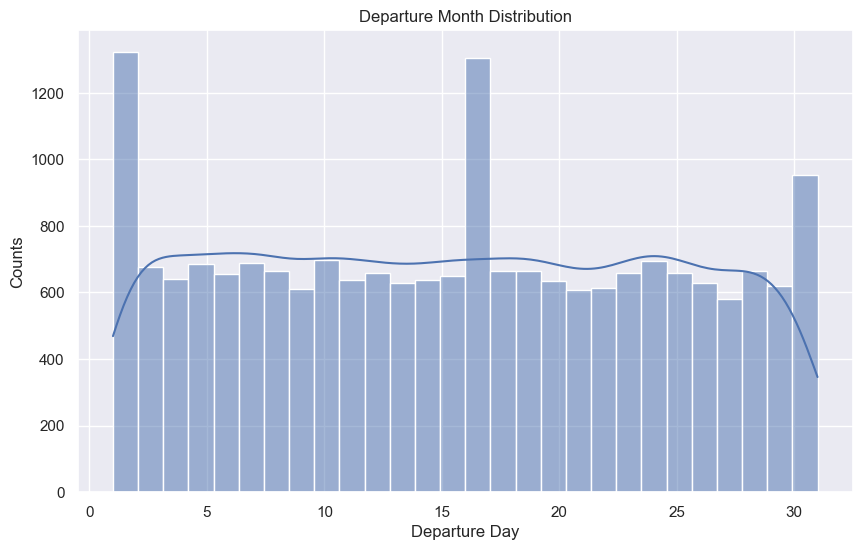

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='departure_day', kde=True)
plt.title("Departure Month Distribution")
plt.ylabel("Counts")
plt.xlabel("Departure Day")
plt.show()

### Pair Plot

<Figure size 1000x800 with 0 Axes>

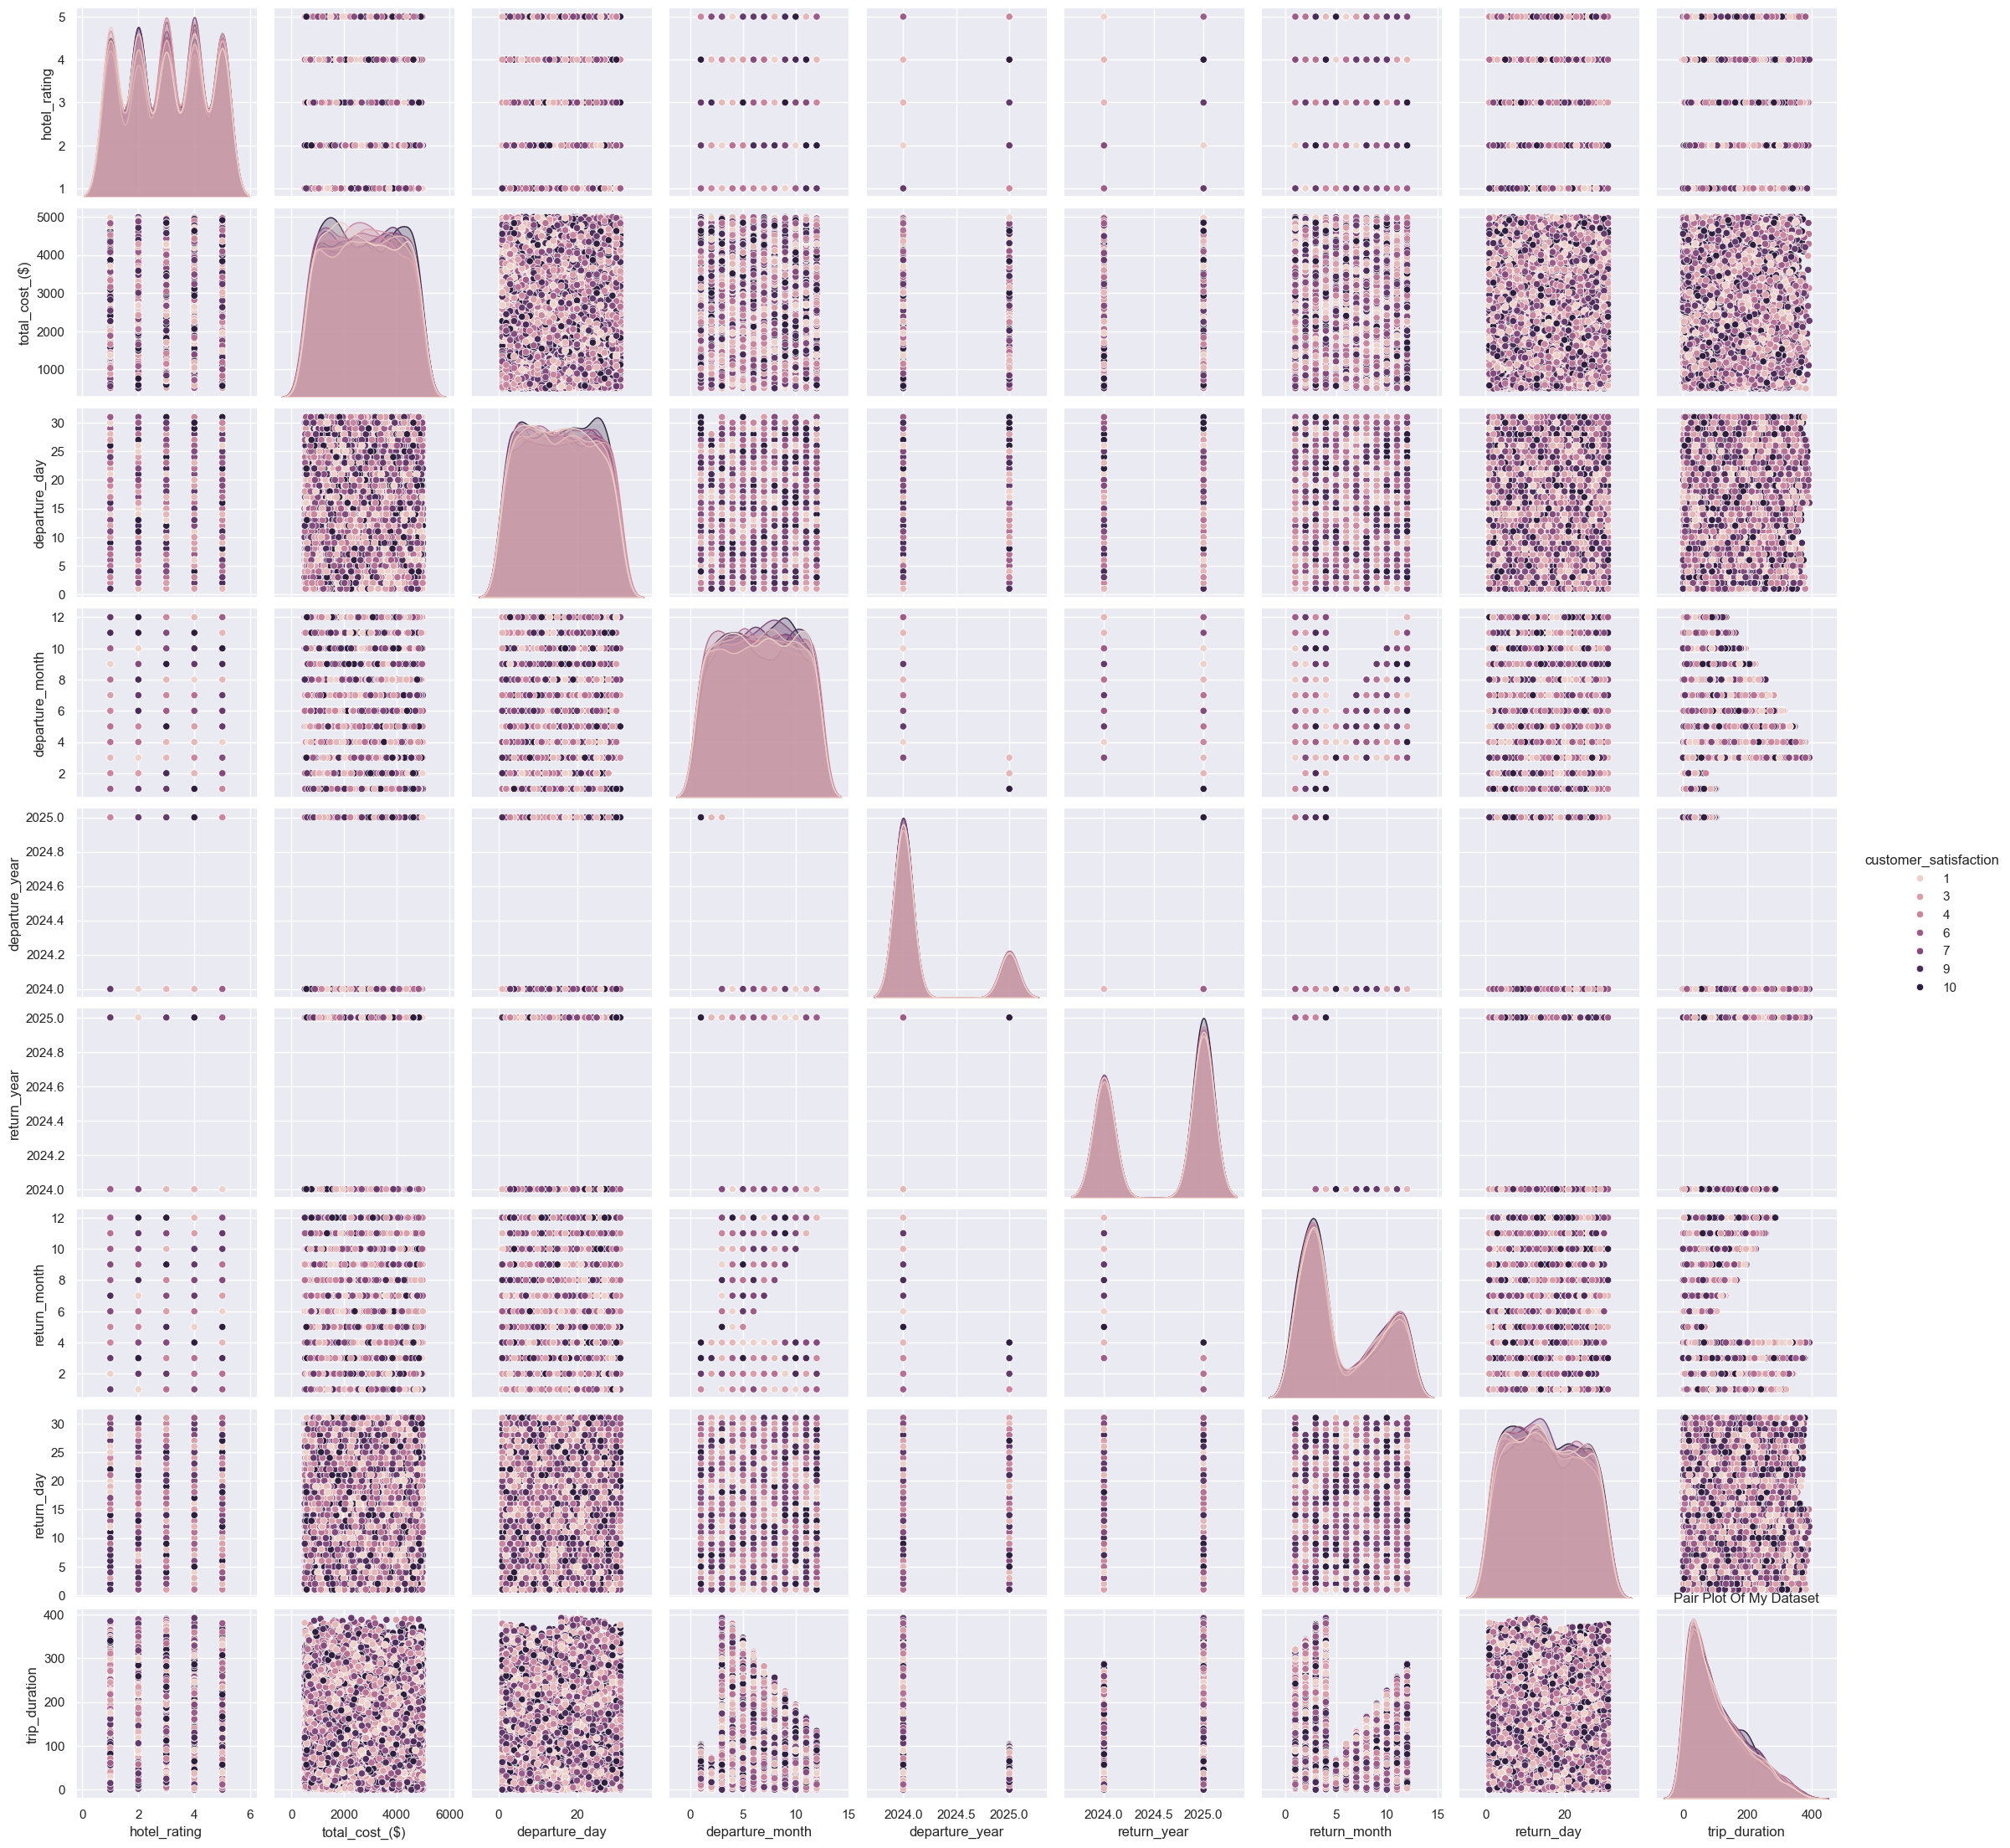

In [53]:
a = df.drop(['trip_id'], axis=1)

plt.figure(figsize=(10, 8))
sns.pairplot(data=a, hue='customer_satisfaction', kind='scatter')
plt.title("Pair Plot Of My Dataset")
plt.show()

# Data Normalisation - Bonus - Model
- Convert object(texts) data columns to descrete or categorical
- Normalise numeric column - trip total cost

### Trip Days Normalisation
- Using log transform because the data is right skewed

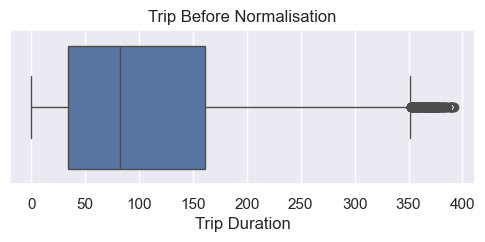

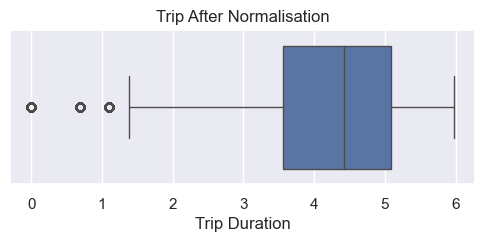

In [54]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['trip_duration'])
plt.title("Trip Before Normalisation")
plt.xlabel("Trip Duration")
plt.show()

df['trip_duration'] = np.log1p(df['trip_duration'])

plt.figure(figsize=(6, 2))
sns.boxplot(x=df['trip_duration'])
plt.title("Trip After Normalisation")
plt.xlabel("Trip Duration")
plt.show()

### Normalise day
- Since days are descrete values, passing a day value to the model is not that effective to learn patterns, but if the days are made into categorical of weeks, that better and provide better insight, instead of just a single value of day

In [55]:
df['departure_week'] = pd.cut(
  df['departure_day'], 
  bins=[0, 7, 14, 21, 31],  # week boundaries
  labels=['Week 1', 'Week 2', 'Week 3', 'Week 4'],
  include_lowest=True
).astype(str)

df['return_week'] = pd.cut(
  df['return_day'], 
  bins=[0, 7, 14, 21, 31],
  labels=['Week 1', 'Week 2', 'Week 3', 'Week 4'],
  include_lowest=True
).astype(str)

### Normalise Object fields - string
- Destination, type_type, transportation mode and weeks.
- I have a dictionary to map the texts-fields unique values to numbers
- Making all texts to lower case.

In [56]:
destination_map = {'sydney': 0,
 'tokyo': 1,
 'new york': 2,
 'bangkok': 3,
 'paris': 4,
 'dubai': 5,
 'istanbul': 6,
 'barcelona': 7,
 'london': 8,
 'rome': 9}

travel_type_map = {'cultural': 0,
 'leisure': 1,
 'business': 2,
 'adventure': 3,
 'beach': 4,
 'family': 5}

transportation_mode_map = {'bus': 0, 'flight': 1, 'cruise': 2, 'train': 3, 'car': 4}

weeks_map = {'week 2': 0, 'week 3': 1, 'week 1': 2, 'week 4': 3}

In [57]:
# make all object - texts to lower case
df = df.astype(str).apply(lambda x: x.str.lower() if x.dtype == 'object' else x )

df['destination'] = df['destination'].map(destination_map)
df['travel_type'] = df['travel_type'].map(travel_type_map)
df['transportation_mode'] = df['transportation_mode'].map(transportation_mode_map)
df['departure_week'] = df['departure_week'].map(weeks_map)
df['return_week'] = df['return_week'].map(weeks_map)

### User Column
- Because there is a lot of users' IDs, I will use the scikit-learn library to make those into mapping for numbers
- The user ID column was not dropped, because some user have trips repeating trips.
- There is about 8011 unique user IDs.
- The dataset has 19800 samples.
- On average a user has about 2 trips in the dataset.
- And There is a user with 10 trips.

In [58]:
vc = df['user_id'].value_counts()
u = df['user_id'].unique().__len__()
u, np.mean(list(vc)), df.shape

(8011, 2.4716015478716766, (19800, 19))

In [59]:
userIdLE = LabelEncoder()
df['user_id'] = userIdLE.fit_transform(df['user_id'])

### Drop columns
- trip_id will be dropped because it is unique to each row and doesn't provide meaningful information
- Because return and departure dates are already processed into year, month and day, for useful information will be droped

In [60]:
df.drop(columns=[
  'trip_id', 'departure_date', 'return_date', 
  'return_year', 'departure_year', 
  'departure_day', 'return_day'
  ], inplace=True)
df.head()

user_id  destination  travel_type  transportation_mode hotel_rating  \
0     4740            0            0                    0            4   
1      345            1            1                    1            3   
2     6648            2            2                    2            4   
3     3837            0            3                    1            2   
4     7820            2            0                    0            2   

  total_cost_($) customer_satisfaction departure_month return_month  \
0        2297.38                     1               7            9   
1        4171.03                     1               1            2   
2         695.11                     3               9            3   
3        1371.81                     3               7            8   
4         691.52                     7               8           11   

        trip_duration  departure_week  return_week  
0  3.8918202981106265               3            0  
1   3.871201010907891               2            1  
2   5.159055299214529               0            2  
3  3.6888794541139363               2            0  
4  4.5217885770490405               3            3

### Correlation Matrix
- Columns are independent of each other, there are no strong linear relationships between most pairs of features. This can be a good sign for machine learning models, as it reduces the risk of multicollinearity.
- 

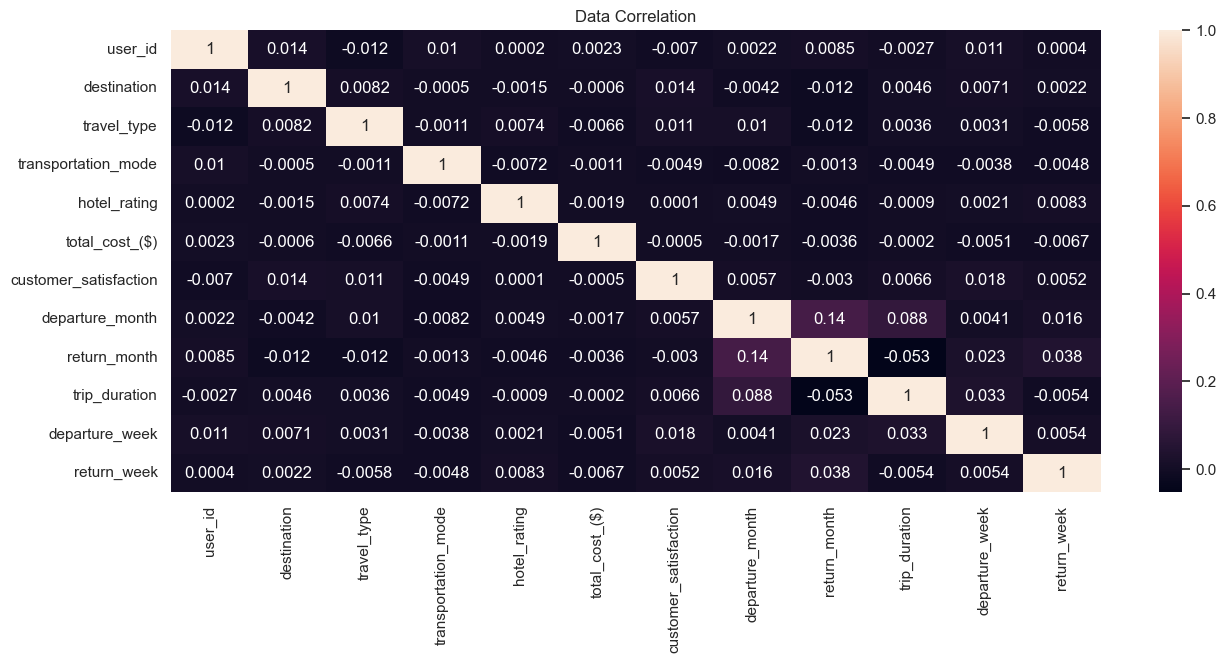

In [61]:
corr = df.corr().round(4)
plt.figure(figsize=(15, 6))
sns.heatmap(corr, annot=True)
# plt.xticks(rotation=30)
plt.title("Data Correlation")
plt.show()

## Model

In [62]:
x = df.drop(columns='customer_satisfaction')
y = df['customer_satisfaction']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [63]:
# Create Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,    # number of trees
    max_depth=None,      # maximum depth of trees
    min_samples_split=2, # minimum samples required to split
    random_state=42      # for reproducibility
)

# Train the model
rf_classifier.fit(x_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



Accuracy: 0.1


In [64]:
# Feature importance (if applicable)
feature_importance = rf_classifier.feature_importances_
feature_importance

array([0.15367466, 0.09202955, 0.0743782 , 0.06561995, 0.05705865,
       0.15444557, 0.07603519, 0.07224641, 0.14268514, 0.05417234,
       0.05765434])

# Reflection
- The most interesting dataset, but it had no missing data, which made me not do much of data cleaning or handling missing values, using any stats method, like using mean, mode, or median or other methods like KNN.
- The is about 19800 samples, and from all the samples, there is 8011 user's ID, meaning most of the users are recorded twice. There is zero(0) duplicate values. The trip ID is unique and there is 19800 unique trip ID, same as the number of trips or samples in the dataset.
- most of the categorical data columns, seems to be very balance between the different unique values in those columns, example, in the transportation mode, travel type and destination country.
- I learn how to extract more data columns from the dataset. Getting the trip duration based on number of days from departure date to return date.
- The trip duration does not have a strong linear influence on the customer satisfaction.
- From the data, I learnt assumptions are not valid, because I was expecting hotel rating, cost of trip or the trip duration to influence the customer satisfaction
- I learn about "correlation does not imply causation"
- I learn about data binning, example with days made into weeks for better insight.
- Based on the information and descriptive statistics, the data columns don't depend on each other.
- There is a lot I need to learn about models, and how to pick models based on the data relationships.
